# Premier League Analysis
Paulo Alting von Geusau, Polina Boneva, Hardit Singh

First, we import all the required packages to work on the project:

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime 
import matplotlib.pyplot as plt
import geopy.distance
import seaborn as sns
from math import sin, cos, sqrt, atan2, radians
pd.set_option('display.max_rows', 10)

In [ ]:
maindf = pd.read_csv('https://raw.githubusercontent.com/harditsingh/DataWranglingVU/master/Project/EPL_Set.csv')
auxiliary_df = pd.read_csv('https://raw.githubusercontent.com/harditsingh/DataWranglingVU/master/Project/EPL%202000-2018.csv')

# Data Preparation

In [ ]:
maindf.isnull().sum()

Div           0
Date          0
HomeTeam      0
AwayTeam      0
FTHG          0
           ... 
FTR           0
HTHG        924
HTAG        924
HTR         924
Season        0
Length: 11, dtype: int64

In [ ]:
def parse_date(text):
  if type(text) is not str:
    return
  for fmt in ('%d/%m/%y', '%d/%m/%Y'):
      try:
          return datetime.strptime(text, fmt)
      except ValueError:
          pass
  raise ValueError('no valid date format found')

# Normalizing the date strings
maindf['Date'] = maindf['Date'].apply(parse_date)
# Dropping the half-time goals and half-time results, since the have missing values
maindf.drop(['HTHG', 'HTAG', 'HTR', 'Div'], inplace=True, axis=1)

auxiliary_df['Date'] = auxiliary_df['Date'].apply(parse_date)
auxiliary_df.drop(['HTHG', 'HTAG', 'HTR', 'HS', 'AS', 'HST', 'AST', 'HC', 'AC'], inplace=True, axis=1)

In [ ]:
# Unique list of teams in the premier league
unique_teams = list(set((maindf['HomeTeam'].unique().tolist() + maindf['AwayTeam'].unique().tolist())))
unique_teams.sort()

In [ ]:
unique_teams.__len__()
print(unique_teams)

['Arsenal', 'Aston Villa', 'Barnsley', 'Birmingham', 'Blackburn', 'Blackpool', 'Bolton', 'Bournemouth', 'Bradford', 'Brighton', 'Burnley', 'Cardiff', 'Charlton', 'Chelsea', 'Coventry', 'Crystal Palace', 'Derby', 'Everton', 'Fulham', 'Huddersfield', 'Hull', 'Ipswich', 'Leeds', 'Leicester', 'Liverpool', 'Man City', 'Man United', 'Middlesboro', 'Middlesbrough', 'Newcastle', 'Norwich', "Nott'm Forest", 'Oldham', 'Portsmouth', 'QPR', 'Reading', 'Sheffield United', 'Sheffield Weds', 'Southampton', 'Stoke', 'Sunderland', 'Swansea', 'Swindon', 'Tottenham', 'Watford', 'West Brom', 'West Ham', 'Wigan', 'Wimbledon', 'Wolves']


The thing is that according to this database, 50 unique teams have participated in the EPL. But accordind to [this article](https://en.wikipedia.org/wiki/List_of_Premier_League_clubs), only 49 teams have been a part of the EPL. When we look closely at the list, we realize that the Middlesboro and Middlesbrough are the same name. To normalize the names, we will be replacing the names in the dataset with the official full names of the teams.

In [ ]:
names_df = pd.read_csv('https://raw.githubusercontent.com/harditsingh/DataWranglingVU/master/Project/names.csv')

In [ ]:
name_dict = {}

for i in range(0,names_df.shape[0]):
  name_dict[names_df.loc[i][0]] = names_df.loc[i][1]
  
maindf.replace(name_dict, inplace=True)

unique_teams = list(set((maindf['HomeTeam'].unique().tolist() + maindf['AwayTeam'].unique().tolist())))
unique_teams.sort()

We then get data for the the attendance of these matches. Since we were unable to find the exact attendance data for each match, we use an average attendance based on the home team for each match

In [ ]:
attendance_files = [ ('/' + str(i) + '_' + str(i+1) + '.csv') for i in range(1993, 2018)]

attendance_files.sort()
base_url = 'https://raw.githubusercontent.com/harditsingh/DataWranglingVU/master/Project/attendance'
attendance_files = [base_url + file_name for file_name in attendance_files]

attendance_data = {}

for i in range(0, maindf['Season'].unique().__len__()):
  temp_df = pd.read_csv(attendance_files[i], decimal=",")

  temp_df.drop('#', axis=1, inplace=True)
  temp_df.drop(temp_df.tail(1).index, inplace=True)
  
  temp_dict = {}
  for j in range(1, temp_df.shape[0] + 1):
    temp_dict[temp_df.loc[j]['Team']] = int(temp_df.loc[j]['average'].replace('.' , ''))
  
  attendance_data[maindf['Season'].unique()[i]] = temp_dict


We then add the attendance data to the main dataframe. The attendance figures for each match are the average attendance numbers for the home team of that match

In [ ]:
maindf['Attendance'] = 0

for i in range(0, maindf.shape[0]):
  try:
    temp_attendance = attendance_data[maindf.iloc[i]['Season']][maindf.iloc[i]['HomeTeam']]
  except KeyError as e:
    temp_attendance = 0

  # Using set_value() instead of .at[]/.iat[] because of compututational time superiority
  maindf.set_value(i, 'Attendance', temp_attendance)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # Remove the CWD from sys.path while we load stuff.


We then import a dataset containing all the information about the home stadiums of all the teams. We use the geographical coordinates of all the stadiums to find the vincenty distance between all of the stadium, which would later be used to see if there is any correlation between the distance that the teams have to travel for a match and the results of the match

In [ ]:
stadium_data = pd.read_csv('https://raw.githubusercontent.com/harditsingh/DataWranglingVU/master/Project/stadiums-premierleague-v2.csv')

In [ ]:
stadium_distance = {}

for i in range(0, stadium_data.shape[0]):
  stadium_distance[stadium_data.iloc[i]['Team']] = {}
  for j in range(0, stadium_data.shape[0]):
    if i != j:
      coords_1 = (stadium_data.iloc[i]['Latitude'], stadium_data.iloc[i]['Longitude'])
      coords_2 = (stadium_data.iloc[j]['Latitude'], stadium_data.iloc[j]['Longitude'])

      distance = geopy.distance.vincenty(coords_1, coords_2).miles
      stadium_distance[stadium_data.iloc[i]['Team']][stadium_data.iloc[j]['Team']] = distance


**NOTE:** In the piece of code above, we add all the distances to a dict containing all the possible pairs of stadiums. This has been done to reduce computation versus calculating the distances on-the-fly, or making multiple passes over the dataframe

In [ ]:
maindf['StadiumDistance'] = 0

for i in range(0, maindf.shape[0]):
  # Using set_value() instead of .at[]/.iat[] because of compututational time superiority
  maindf.set_value(i, 'StadiumDistance', stadium_distance[maindf.iloc[i]['HomeTeam']][maindf.iloc[i]['AwayTeam']])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  """


Finally, after the cleanup, this is what are dataset looks like:

In [3]:
maindf

NameError: name 'maindf' is not defined

We now continue cleaning the auxiliary dataset which has the data for seasons from 2000-01 onwards

In [ ]:
# Cleaning up referee names (wrong spelling)
cleaned_df = auxiliary_df.replace(["�A D'Urso", "Andy D'Urso", "Andy D'Urso "], "A D'Urso")
cleaned_df = cleaned_df.replace("�U Rennie", "U Rennie")
cleaned_df = cleaned_df.replace("�C Foy", "C Foy")
cleaned_df = cleaned_df.replace(["�A Wiley","Alan Wiley"], "A Wiley")
cleaned_df = cleaned_df.replace(["�D Gallagher", "Dermot Gallagher", "D Gallagh", "D Gallaghe"], "D Gallagher")
cleaned_df = cleaned_df.replace("�H Webb", "H Webb")
cleaned_df = cleaned_df.replace(["�M Atkinson","Mn Atkinson"], "M Atkinson")
cleaned_df = cleaned_df.replace(["�N Barry", "Neale Barry"], "N Barry")
cleaned_df = cleaned_df.replace(["�S Dunn", "Steve Dunn"], "S Dunn")
cleaned_df = cleaned_df.replace("Graham Barber", "G Barber")
cleaned_df = cleaned_df.replace("Barry Knight", "B Knight")
cleaned_df = cleaned_df.replace("Mike Riley", "M Riley")
cleaned_df = cleaned_df.replace("Paul Durkin", "P Durkin")
cleaned_df = cleaned_df.replace("Graham Poll", "G Poll")
cleaned_df = cleaned_df.replace(["Mark Halsey", "Mark Halsey "], "M Halsey")
cleaned_df = cleaned_df.replace("Jeff Winter", "J Winter")
cleaned_df = cleaned_df.replace("Rob Styles", "R Styles")
cleaned_df = cleaned_df.replace(["Steve Bennett", "Steve Bennett ", "St Bennett"], "S Bennett")
cleaned_df = cleaned_df.replace("Mike Dean", "M Dean")
cleaned_df = cleaned_df.replace("Matt Messias", "M Messias")
cleaned_df = cleaned_df.replace("Clive Wilkes", "C Wilkes")
cleaned_df = cleaned_df.replace("l Mason", "L Mason")

In [ ]:
cleaned_df.Referee.unique()

array(['Rob Harris', 'G Barber', 'B Knight', "A D'Urso", 'D Gallagher',
       'M Riley', 'P Durkin', 'S Dunn', 'A Wiley', 'Steve Lodge',
       'G Poll', 'M Halsey', 'J Winter', 'Peter Jones', 'Andy Hall',
       'David Ellaray', 'F Taylor', 'R Styles', 'S Bennett', 'Ian Harris',
       'Paul Taylor', 'N Barry', 'M Dean', 'Roy Burton', 'M Messias',
       'C Wilkes', 'D Elleray', 'U Rennie', 'D Pugh', 'E Wolstenholme',
       'C Foy', 'P Dowd', 'R Martin', 'H Webb', 'P Walton',
       'M Clattenburg', 'M Atkinson', 'P Crossley', 'A Marriner',
       'R Beeby', 'I Williamson', 'L Mason', 'K Stroud', 'S Tanner',
       'L Probert', 'S Attwell', 'M Jones', 'K Friend', 'A Taylor',
       'M Oliver', 'N Swarbrick', 'J Moss', 'R East', 'C Pawson',
       'R Madley', 'P Tierney', 'G Scott', nan, 'S Hooper', 'C Kavanagh',
       'D Coote'], dtype=object)

In [ ]:
# Checking if unique teams is correct
print("There are", cleaned_df.HomeTeam.nunique(), "unique teams")
cleaned_df.head(2)


There are 44 unique teams


,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Referee,HF,AF,HY,AY,HR,AR,Season
0,2000-08-19,Charlton,Man City,4.0,0.0,H,Rob Harris,13.0,12.0,1.0,2.0,0.0,0.0,00-01
1,2000-08-19,Chelsea,West Ham,4.0,2.0,H,G Barber,19.0,14.0,1.0,2.0,0.0,0.0,00-01


In [ ]:
# Delete season 00-01
season_00_01 = cleaned_df[ cleaned_df['Season'] == '00-01'].index
 
# Delete these rows indexes from dataFrame
cleaned_df.drop(season_00_01 , inplace=True)

In [ ]:
# Goal difference column
cleaned_df['GoalsDifference'] = cleaned_df['FTHG'] - cleaned_df['FTAG']

In [ ]:
# Show missing row
null_data = cleaned_df[cleaned_df.isnull().any(axis=1)]
null_data
# Delete row with index label '5320' 
cleaned_df = cleaned_df.drop(5320)

In [ ]:
# Checking for missing values
cleaned_df.isnull().sum()
cleaned_df.isnull().values.any()

False

In [ ]:
cleaned_df[['FTHG', 'FTAG', 'HF', 'AF', 'HY', 'AY', 'HR', 'AR', 'GoalsDifference']] = cleaned_df[['FTHG', 'FTAG', 'HF', 'AF', 'HY', 'AY', 'HR', 'AR', 'GoalsDifference']].astype(int)

In [ ]:
# Checking if seasons are correct
cleaned_df.Season.value_counts()

04-05    380
12-13    380
02-03    380
15-16    380
14-15    380
10-11    380
13-14    380
17-18    380
11-12    380
16-17    380
05-06    380
08-09    380
06-07    380
03-04    380
07-08    380
09-10    380
Name: Season, dtype: int64

In [ ]:
cleaned_df.describe()

,FTHG,FTAG,HF,AF,HY,AY,HR,AR,GoalsDifference
count,6080.000000,6080.000000,6080.000000,6080.000000,6080.000000,6080.000000,6080.000000,6080.000000,6080.000000
mean,1.530263,1.131908,11.389803,11.943750,1.397204,1.759868,0.062993,0.094079,0.398355
std,1.299046,1.127955,3.722532,3.857444,1.178979,1.278558,0.255511,0.303564,1.766664
min,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-6.000000
25%,1.000000,0.000000,9.000000,9.000000,0.000000,1.000000,0.000000,0.000000,-1.000000
50%,1.000000,1.000000,11.000000,12.000000,1.000000,2.000000,0.000000,0.000000,0.000000
75%,2.000000,2.000000,14.000000,14.000000,2.000000,3.000000,0.000000,0.000000,1.000000
max,9.000000,7.000000,33.000000,28.000000,7.000000,9.000000,3.000000,2.000000,8.000000


In [ ]:
cleaned_df.head(5)

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Referee,HF,AF,HY,AY,HR,AR,Season,GoalsDifference
380,2002-08-17,Blackburn,Sunderland,0,0,D,D Elleray,14,11,1,2,0,0,02-03,0
381,2002-08-17,Charlton,Chelsea,2,3,A,G Barber,10,12,0,3,1,0,02-03,-1
382,2002-08-17,Everton,Tottenham,2,2,D,N Barry,18,4,1,1,0,0,02-03,0
383,2002-08-17,Fulham,Bolton,4,1,H,A Wiley,16,12,1,2,0,0,02-03,3
384,2002-08-17,Leeds,Man City,3,0,H,G Poll,13,13,1,1,0,0,02-03,3


In [ ]:
grouped = cleaned_df.groupby('Season')

def foul_count(season):
    
    result_fouls = {}
    
    teams = season['HomeTeam']
    for i in teams:
        
        home_games = season[season['HomeTeam']==i]
        away_games = season[season['AwayTeam']==i]
        
        games = len(home_games) + len(away_games)
        
        home_fouls = home_games['HF'].sum()
        away_fouls = away_games['AF'].sum()
        
        total_fouls = home_fouls + away_fouls
        
        result_fouls[i] = round(total_fouls / games,2)
        
    return result_fouls

In [ ]:
result_fouls = grouped.apply(foul_count)
result_fouls

Season
02-03    {'Blackburn': 13.92, 'Charlton': 12.97, 'Evert...
03-04    {'Arsenal': 13.13, 'Birmingham': 13.29, 'Black...
04-05    {'Aston Villa': 15.26, 'Blackburn': 15.61, 'Bo...
05-06    {'Aston Villa': 14.13, 'Everton': 14.08, 'Fulh...
06-07    {'Arsenal': 9.68, 'Bolton': 13.71, 'Everton': ...
07-08    {'Aston Villa': 13.37, 'Bolton': 13.11, 'Derby...
08-09    {'Arsenal': 11.03, 'Bolton': 13.08, 'Everton':...
09-10    {'Aston Villa': 12.11, 'Blackburn': 13.84, 'Bo...
10-11    {'Aston Villa': 11.5, 'Blackburn': 11.97, 'Bol...
11-12    {'Blackburn': 11.18, 'Fulham': 9.21, 'Liverpoo...
12-13    {'Arsenal': 9.47, 'Fulham': 10.11, 'Newcastle'...
13-14    {'Arsenal': 9.16, 'Liverpool': 10.79, 'Norwich...
14-15    {'Arsenal': 9.92, 'Leicester': 12.03, 'Man Uni...
15-16    {'Bournemouth': 9.53, 'Chelsea': 10.74, 'Evert...
16-17    {'Burnley': 11.21, 'Crystal Palace': 12.34, 'E...
17-18    {'Arsenal': 10.08, 'Brighton': 10.87, 'Chelsea...
dtype: object

In [ ]:
# Rank team with highest foul for seasons
foul_rate_list = []

for i in result_fouls:
    n = max(zip(i.values(),i.keys()))
    foul_rate_list.append(n)

foul_rate_list

[(14.39, 'Leeds'),
 (14.84, 'Tottenham'),
 (15.61, 'Blackburn'),
 (15.79, 'Newcastle'),
 (14.79, 'Watford'),
 (13.97, 'Blackburn'),
 (14.03, 'Hull'),
 (13.84, 'Blackburn'),
 (12.63, 'Bolton'),
 (11.82, 'Everton'),
 (11.71, 'West Ham'),
 (12.76, 'Stoke'),
 (13.87, 'Crystal Palace'),
 (12.42, 'Man United'),
 (13.61, 'Watford'),
 (12.08, 'Everton')]

# Basic Data Exploration
Before we move any further, we must analyze the data that we have currently to see if any trends are already visible. First, let's take a look at the match database.

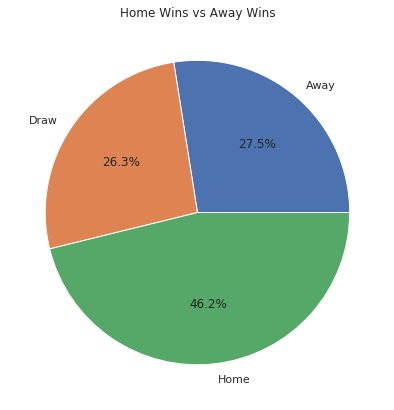

In [ ]:
# Total home wins, away wins, draws
results = maindf.groupby('FTR')['FTR'].count()
plt.pie(results, labels=['Away', 'Draw', 'Home'], autopct='%1.1f%%')
plt.title('Home Wins vs Away Wins')
plt.show()

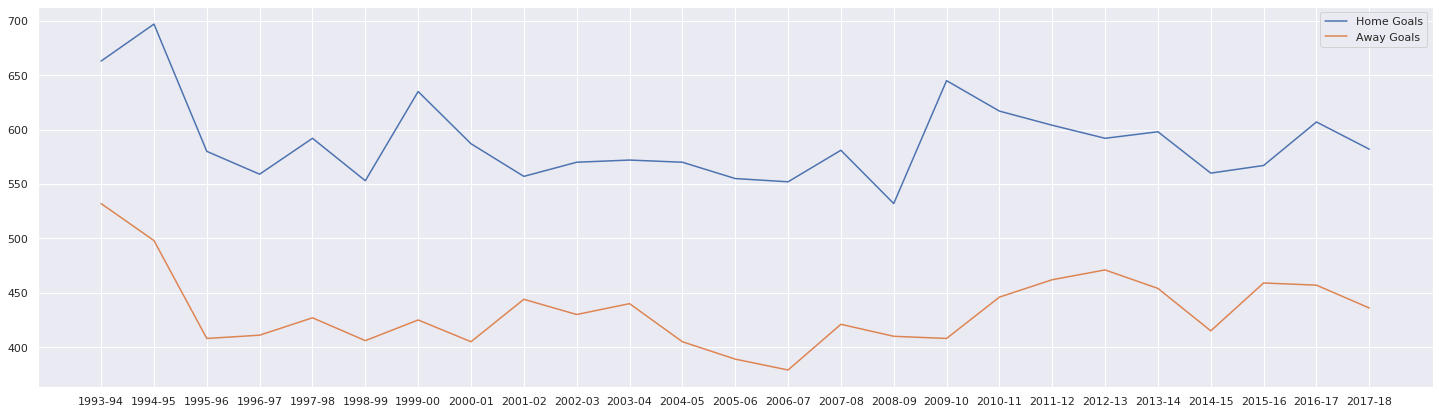

In [ ]:
total_goals = maindf[['FTAG', 'FTHG', 'Season']]

sns.set(rc={'figure.figsize':(25,7)})
plt.plot(total_goals[['FTHG', 'Season']].groupby('Season').sum()['FTHG'], label='Home Goals')
plt.plot(total_goals[['FTAG', 'Season']].groupby('Season').sum()['FTAG'], label='Away Goals')
plt.legend()

# Data Analysis

## Checking for correlation

We start out by checking correlation between the obvious suspects with the home performance of the teams, the Stadium Distance and the Attendance

In [ ]:
# We first create a column GoalDifference, which would be FTHG - FTAG
maindf['GoalDifference'] = maindf['FTHG'] - maindf['FTAG']
maindf

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Season,Attendance,StadiumDistance,GoalDifference
0,1993-08-14,Arsenal FC,Coventry City,0,3,A,1993-94,30564,85,-3
1,1993-08-14,Aston Villa,Queens Park Rangers,4,1,H,1993-94,29015,98,3
2,1993-08-14,Chelsea FC,Blackburn Rovers,1,2,A,1993-94,19416,183,-1
3,1993-08-14,Liverpool FC,Sheffield Wednesday,2,0,H,1993-94,38503,60,2
4,1993-08-14,Manchester City,Leeds United,1,1,D,1993-94,26709,32,0
...,...,...,...,...,...,...,...,...,...,...
9659,2018-05-13,Newcastle United,Chelsea FC,3,0,H,2017-18,51992,248,3
9660,2018-05-13,Southampton FC,Manchester City,0,1,A,2017-18,30794,181,-1
9661,2018-05-13,Swansea City,Stoke City,1,2,A,2017-18,20623,119,-1
9662,2018-05-13,Tottenham Hotspur,Leicester City,5,4,H,2017-18,67953,83,1


Now we'll take a look at the distributions of Stadium Distance and Attendance to check for skewness

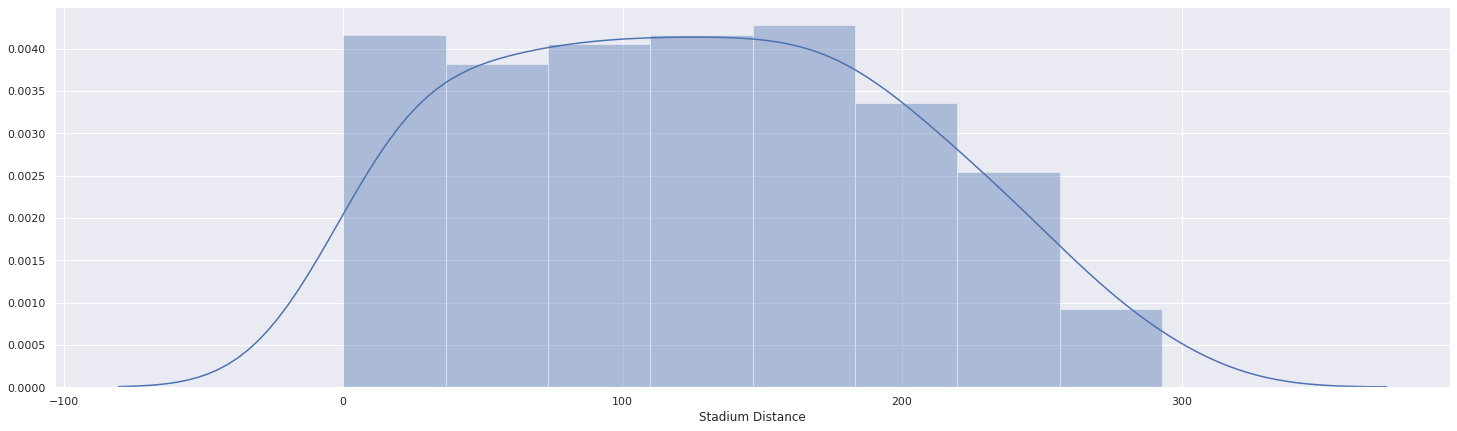

In [ ]:
sns.distplot(maindf['StadiumDistance'].unique(), axlabel='Stadium Distance')

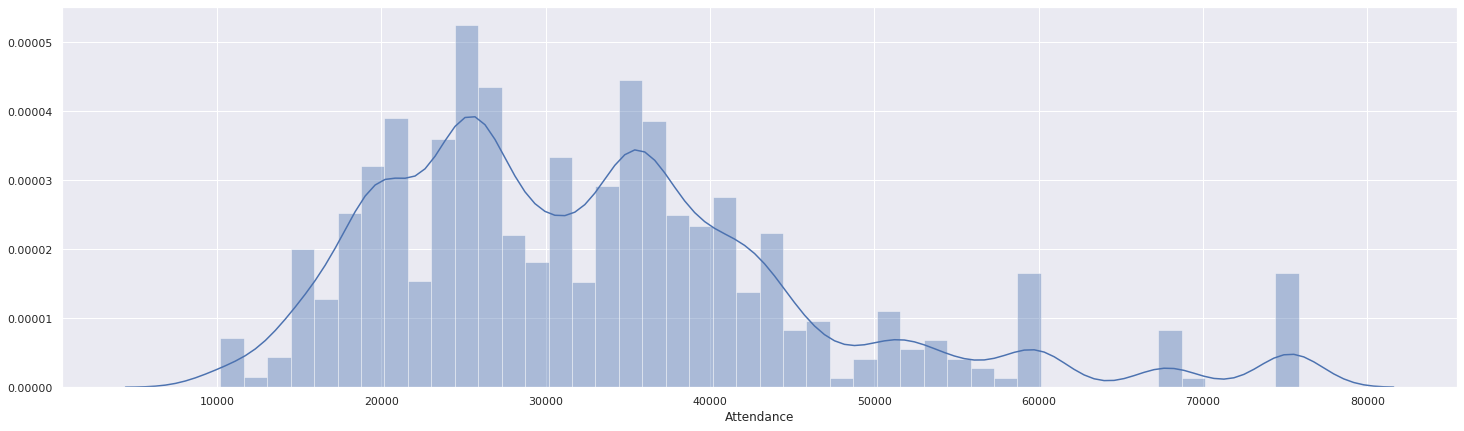

In [ ]:
sns.distplot(maindf['Attendance'])

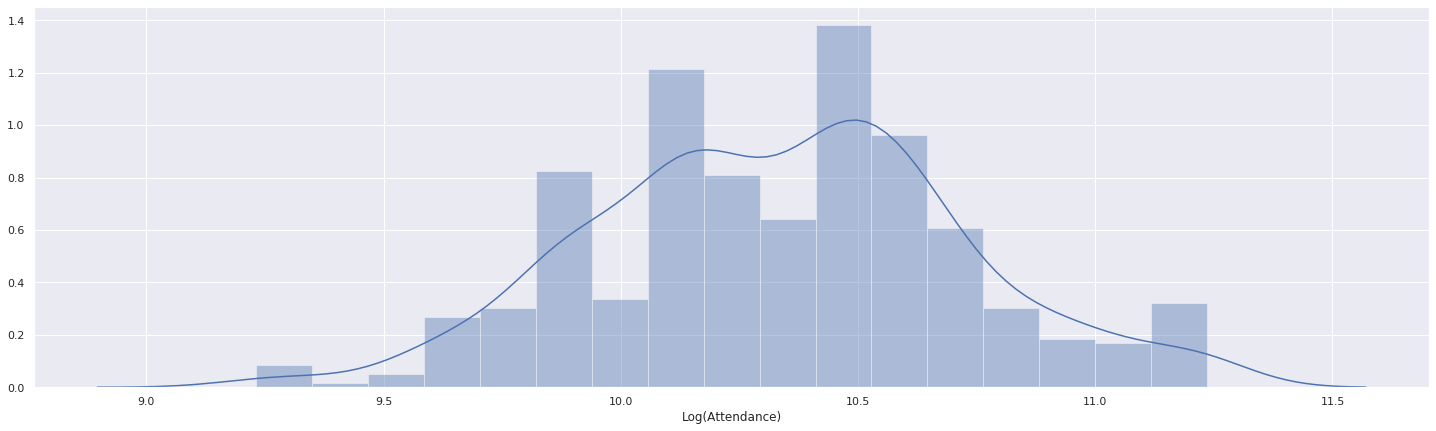

In [ ]:
# Normalized attendance data
sns.distplot(np.log(maindf['Attendance'].unique()), axlabel='Log(Attendance)')

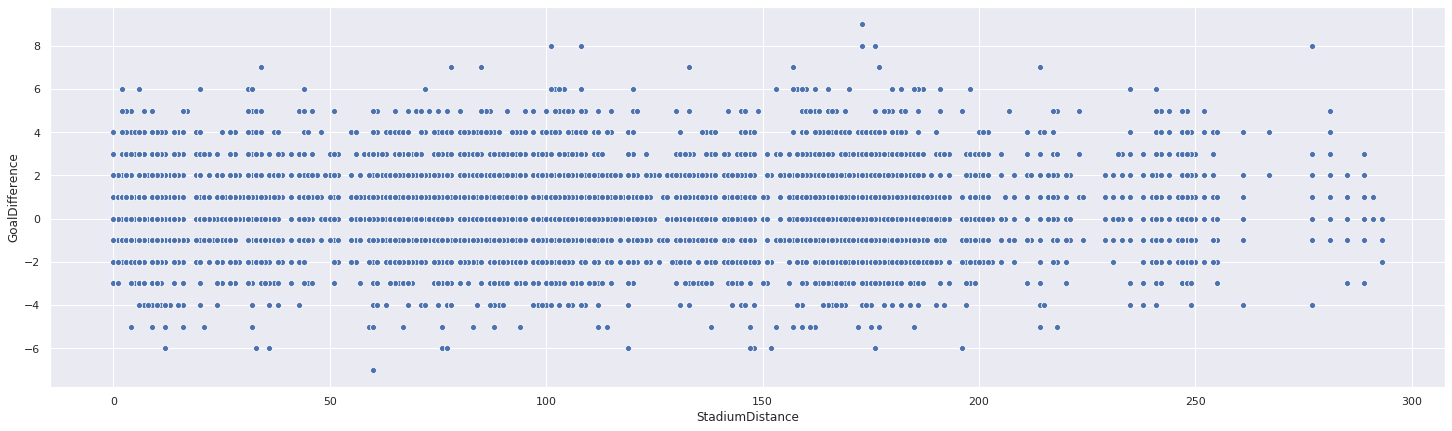

In [ ]:
sns.scatterplot(maindf['StadiumDistance'], maindf['GoalDifference'])

Checking the Pearson's correlation coefficient for GoalDifference and StadiumDistance and GoalDifference and Log(Attendance)

In [ ]:
np.corrcoef(maindf['GoalDifference'], maindf['StadiumDistance'])[0,1]

0.03843102099058685

In [ ]:
np.corrcoef(maindf['GoalDifference'], np.log(maindf['Attendance']))[0,1]

0.22228906011096314

## Match Statitics
We will now create multiple different tables for the different aspects of the game of football, which will facilitate our analysis and help us in finding patterns

### Yearly Match Rankings

Here we create a point based ranking table, 3 points for a win, 1 point for a draw. 

In [ ]:
match_results = {}

def get_results(result_table, winloss):
  try:
    result = result_table[winloss]
  except KeyError as e:
    result = 0
  return result


for season in maindf['Season'].unique():
  listtemp = []
  results_home = maindf[maindf['Season'] == season][['HomeTeam', 'FTR']].groupby('HomeTeam').FTR.value_counts()
  results_away = maindf[maindf['Season'] == season][['AwayTeam', 'FTR']].groupby('AwayTeam').FTR.value_counts()
  home_fthg = maindf[maindf['Season'] == season][['HomeTeam', 'GoalDifference']].groupby('HomeTeam').sum()
  away_ftag = maindf[maindf['Season'] == season][['AwayTeam', 'GoalDifference']].groupby('AwayTeam').sum()

  for key in unique_teams:
    try:
      wins = get_results(results_home[key], 'H') + get_results(results_away[key], 'A')
      losses = get_results(results_home[key], 'A') + get_results(results_away[key], 'H')
      draws = get_results(results_home[key], 'D') + get_results(results_away[key], 'D')
      goals = home_fthg.loc[key]['GoalDifference'] - away_ftag.loc[key]['GoalDifference']
      listtemp.append([key, wins, losses, draws, goals])
    except KeyError as e:
      continue
  
  match_results[season] = pd.DataFrame(listtemp, columns=['Team', 'Wins', 'Losses', 'Draws', 'GoalDifference'])
  match_results[season]['FinalPoints'] = (match_results[season]['Wins'] * 3) + match_results[season]['Draws']



The dict match_results contains dataframes for all seasons from 1993 up until 2018

In [ ]:
match_results['2017-18'].sort_values(['FinalPoints', 'GoalDifference'], ascending=False)

,Team,Wins,Losses,Draws,GoalDifference,FinalPoints
10,Manchester City,32,2,4,79,100
11,Manchester United,25,7,6,40,81
16,Tottenham Hotspur,23,7,8,38,77
9,Liverpool FC,21,5,12,46,75
4,Chelsea FC,21,10,7,24,70
...,...,...,...,...,...,...
7,Huddersfield Town,9,19,10,-30,37
13,Southampton FC,7,16,15,-19,36
15,Swansea City,8,21,9,-28,33
14,Stoke City,7,19,12,-33,33


### Lifetime wins/losses
Here we calculate the lifetime wins and losses of all the teams that ever participated in the premier league

In [ ]:
# Total lifetime wins/losses
listtemp = []

for key in unique_teams:
  wins = losses = draws = goals = 0

  for season in maindf['Season'].unique():
    
    results_home = maindf[maindf['Season'] == season][['HomeTeam', 'FTR']].groupby('HomeTeam').FTR.value_counts()
    results_away = maindf[maindf['Season'] == season][['AwayTeam', 'FTR']].groupby('AwayTeam').FTR.value_counts()
    home_fthg = maindf[maindf['Season'] == season][['HomeTeam', 'GoalDifference']].groupby('HomeTeam').sum()
    away_ftag = maindf[maindf['Season'] == season][['AwayTeam', 'GoalDifference']].groupby('AwayTeam').sum()

    try:
      wins += get_results(results_home[key], 'H') + get_results(results_away[key], 'A')
      losses += get_results(results_home[key], 'A') + get_results(results_away[key], 'H')
      draws += get_results(results_home[key], 'D') + get_results(results_away[key], 'D')
      goals += home_fthg.loc[key]['GoalDifference'] - away_ftag.loc[key]['GoalDifference']
    except KeyError as e:
      continue

  listtemp.append([key, wins, losses, draws, goals])

lifetime_results = pd.DataFrame(listtemp, columns=['Team', 'Wins', 'Losses', 'Draws', 'GoalDifference'])


In [ ]:
lifetime_results.sort_values(['Wins', 'Draws', 'Losses'], ascending=False)

,Team,Wins,Losses,Draws,GoalDifference
26,Manchester United,605,150,203,1013
1,Arsenal FC,529,187,242,808
13,Chelsea FC,523,201,234,747
24,Liverpool FC,483,231,244,654
42,Tottenham Hotspur,407,307,244,219
...,...,...,...,...,...
31,Oldham Athletic,9,20,13,-26
9,Brighton & Hove Albion,9,16,13,-20
19,Huddersfield Town,9,19,10,-30
11,Cardiff City,7,22,9,-42


### Lifetime goals scored
Here we calculate the lifetime goals scored by all the teams that ever participated in the premier league

In [ ]:
# Total lifetime goals
listtemp = []

for key in unique_teams:
  goals = 0

  for season in maindf['Season'].unique():
    home_fthg = maindf[maindf['Season'] == season][['HomeTeam', 'FTHG']].groupby('HomeTeam').sum()
    away_ftag = maindf[maindf['Season'] == season][['AwayTeam', 'FTAG']].groupby('AwayTeam').sum()

    try:
      goals += home_fthg.loc[key]['FTHG'] + away_ftag.loc[key]['FTAG']
    except KeyError as e:
      continue

  listtemp.append([key, goals])

lifetime_goals = pd.DataFrame(listtemp, columns=['Team', 'Goals'])


In [ ]:
lifetime_goals.sort_values(['Goals'], ascending=False)

,Team,Goals
26,Manchester United,1857
1,Arsenal FC,1732
13,Chelsea FC,1656
24,Liverpool FC,1623
42,Tottenham Hotspur,1420
...,...,...
31,Oldham Athletic,42
3,Barnsley FC,37
9,Brighton & Hove Albion,34
11,Cardiff City,32


### Yearly goal difference
Here, we calculate the goal difference for all the teams that participated in the premier league, and then make a heatmap to visualize how each team performed. The grey cells indicate the fact that the team did not participate in the premier league in that season

In [ ]:
# Yearly goal difference
listtemp = []

for key in unique_teams:
  team_list = [key]

  for season in maindf['Season'].unique():
    goal_difference = 0
    home_fthg = maindf[maindf['Season'] == season][['HomeTeam', 'GoalDifference']].groupby('HomeTeam').sum()
    away_ftag = maindf[maindf['Season'] == season][['AwayTeam', 'GoalDifference']].groupby('AwayTeam').sum()

    try:
      goal_difference += home_fthg.loc[key]['GoalDifference'] - away_ftag.loc[key]['GoalDifference']
    except KeyError as e:
      team_list.append(np.nan)
      continue

    team_list.append(goal_difference)
  listtemp.append(team_list)


cols = ['Teams'] + list(maindf['Season'].unique())
yearly_goal_difference = pd.DataFrame(listtemp, columns=cols)


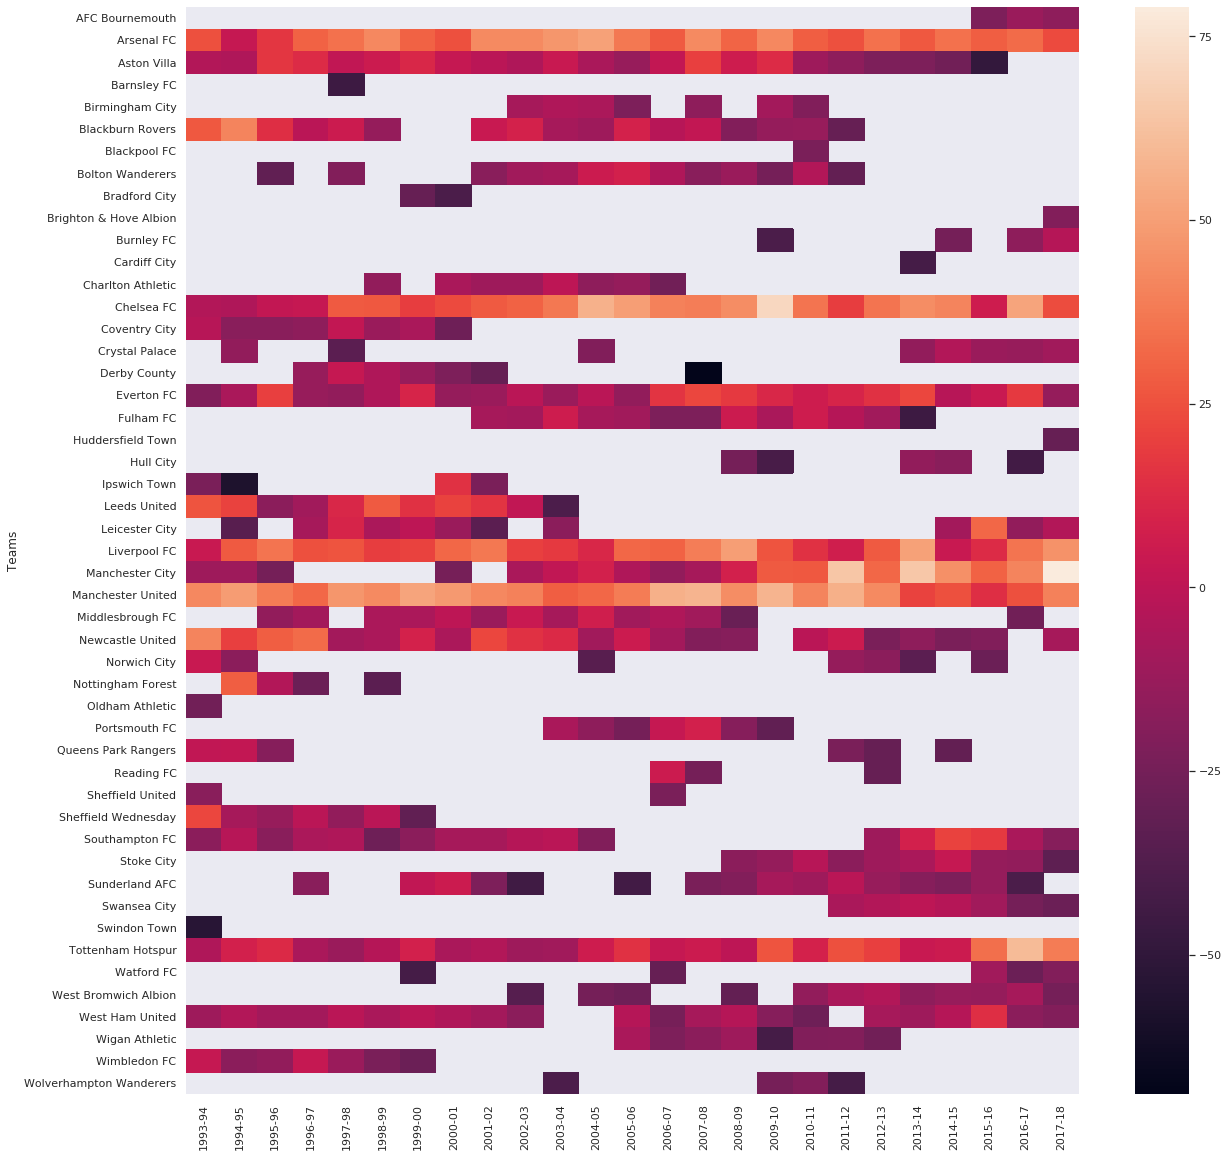

In [ ]:
mask = yearly_goal_difference.set_index(['Teams']).isnull()
sns.set(rc={'figure.figsize':(20,20)})
sns.heatmap(yearly_goal_difference.set_index(['Teams']), mask=mask)
sns.set(rc={'figure.figsize':(25,7)})

## Market Values
In this section, we import data for the market values for all the teams. Unfortunately, the only available data was from the year 2011 on, so we were unable to perform the analysis for the market value for years prior to 2011.

In [ ]:
market_value_years = [('20' + str(i) + '-' + str(i+1)) for i in range(11, 19)]
market_value_files = [('/' + str(i) + '.csv') for i in range(2011, 2019)]

base_url = 'https://raw.githubusercontent.com/harditsingh/DataWranglingVU/master/Project/MarketValue'
market_value_files = [base_url + file_name for file_name in market_value_files]

market_value_data = {}

for team in unique_teams:
  market_value_data[team] = {} 

for i in range(0, market_value_files.__len__()):
  values = pd.read_csv(market_value_files[i])

  values = values[values.keys()[[2, 4]]].iloc[1:]
  values.columns = ['Team', 'Value']
  values.Value = values.Value.str.replace('€', '')
  values.Value = values.Value.str.replace('bn', 'b')
  values['Value'] = (values['Value'].replace(r'[kmb]+$', '', regex=True).astype(float) * values['Value'].str.extract(r'[\d\.]+([kmb]+)', expand=False).fillna(1).replace(['k','m', 'b'], [10**3, 10**6, 10**9]).astype(int))

  for j in range(1, values.shape[0]):
    market_value_data[values.loc[j]['Team']][market_value_years[i]] = values.loc[j]['Value']



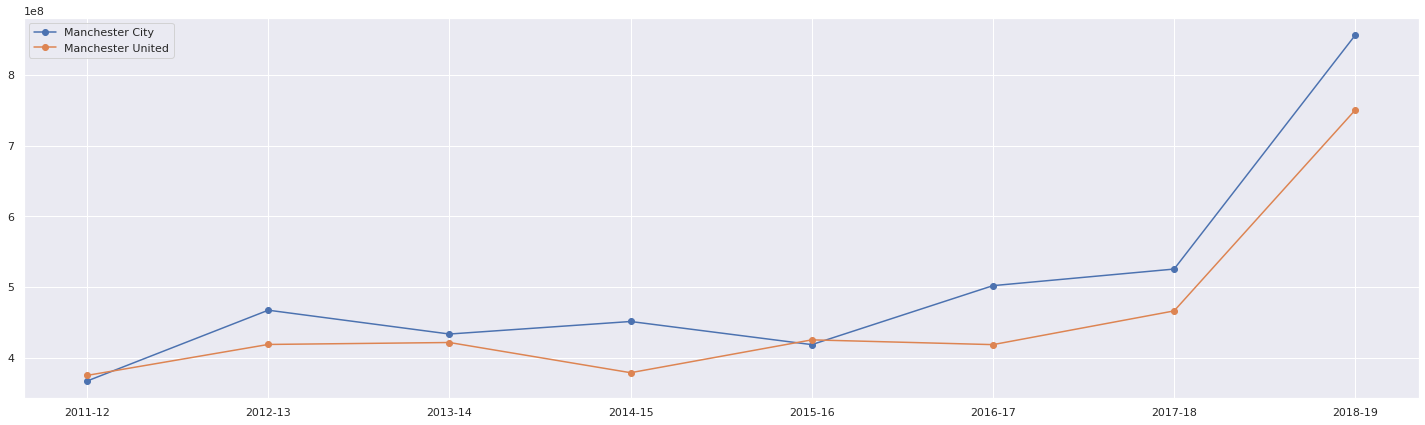

In [ ]:
plt.plot(list(market_value_data['Manchester City'].keys()), list(market_value_data['Manchester City'].values()), marker='o', label="Manchester City")
plt.plot(list(market_value_data['Manchester United'].keys()), list(market_value_data['Manchester United'].values()), marker='o', label="Manchester United")
plt.legend()

## Home Advantage
To explore the home advantage further, we calculated home advantage score for each team for each year. This was an attempt to replicate the scores generated by the football statistics website Footystats([check out the table here](https://footystats.org/england/premier-league/home-advantage-table)). 

After some brainstorming, we came up with some formulas which seemed to give us similar results:
![formulas for home advantage scores](https://github.com/harditsingh/DataWranglingVU/raw/master/Project/home_advantage_scoring_formula.png)

In [ ]:
scoring_advantage_dict = {}

for season in maindf['Season'].unique():
  listtemp = []
  home_fthg = maindf[maindf['Season'] == season][['HomeTeam', 'FTHG']].groupby('HomeTeam').sum()
  away_ftag = maindf[maindf['Season'] == season][['AwayTeam', 'FTAG']].groupby('AwayTeam').sum()

  for key in unique_teams:
    try:
      home = home_fthg.loc[key]['FTHG'] / 19
      away = away_ftag.loc[key]['FTAG'] / 19
      scoring_advantage = (home - away) / (home + away) * 100
      listtemp.append([key, scoring_advantage, home, away ])
    except KeyError as e:
      continue
  
  scoring_advantage_dict[season] = pd.DataFrame(listtemp, columns=['Team', 'ScoringAdvantage', 'Home', 'Away'])


In [ ]:
defense_advantage_dict = {}

for season in maindf['Season'].unique():
  listtemp = []
  home_fthg = maindf[maindf['Season'] == season][['HomeTeam', 'FTAG']].groupby('HomeTeam').sum()
  away_ftag = maindf[maindf['Season'] == season][['AwayTeam', 'FTHG']].groupby('AwayTeam').sum()

  for key in unique_teams:
    try:
      home = home_fthg.loc[key]['FTAG'] / 19
      away = away_ftag.loc[key]['FTHG'] / 19
      scoring_advantage = (away - home) / (home + away) * 100
      listtemp.append([key, scoring_advantage, home, away ])
    except KeyError as e:
      continue
  
  defense_advantage_dict[season] = pd.DataFrame(listtemp, columns=['Team', 'DefenseAdvantage', 'Home', 'Away'])


In [ ]:
home_advantage_dict = {}

for season in maindf['Season'].unique():
  home_advantage_dict[season] = scoring_advantage_dict[season][['Team', 'ScoringAdvantage']]
  home_advantage_dict[season]['DefenseAdvantage'] = defense_advantage_dict[season]['DefenseAdvantage']
  home_advantage_dict[season]['HomeAdvantage'] = (home_advantage_dict[season]['ScoringAdvantage'] + home_advantage_dict[season]['DefenseAdvantage']) / 2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
home_advantage_dict['2015-16'].sort_values(by=['HomeAdvantage'], ascending=False)

,Team,ScoringAdvantage,DefenseAdvantage,HomeAdvantage
10,Newcastle United,45.454545,26.153846,35.804196
9,Manchester United,10.204082,48.571429,29.387755
11,Norwich City,33.333333,10.447761,21.890547
1,Arsenal FC,-4.615385,38.888889,17.136752
14,Sunderland AFC,-4.166667,35.483871,15.658602
...,...,...,...,...
4,Crystal Palace,-2.564103,9.803922,3.619910
6,Leicester City,2.941176,0.000000,1.470588
19,West Ham United,4.615385,-1.960784,1.327300
0,AFC Bournemouth,2.222222,-1.492537,0.364842


We then prepared the yearly home advantage scores in order to plot them and compare the performances of the teams

In [ ]:
listtemp = []

for key in unique_teams:
  team_list = [key]

  for season in maindf['Season'].unique():
    goals = 0
    temp = home_advantage_dict[season][home_advantage_dict[season]['Team'] == key]['HomeAdvantage'].values
    home_advantage = np.nan if (temp.__len__() == 0) else temp[0]
    try:
      team_list.append(home_advantage)
    except KeyError as e:
      team_list.append(np.nan)
      continue

  listtemp.append(team_list)

cols = ['Teams'] + list(maindf['Season'].unique())

yearly_home_advantage = pd.DataFrame(listtemp, columns=cols)


We also calculated the mean home advantage scores for each season in order to have a better perspective about the situation every season

In [ ]:
transposed = yearly_home_advantage.set_index('Teams').T
transposed['Mean'] = transposed.mean(axis = 1, skipna = True) 

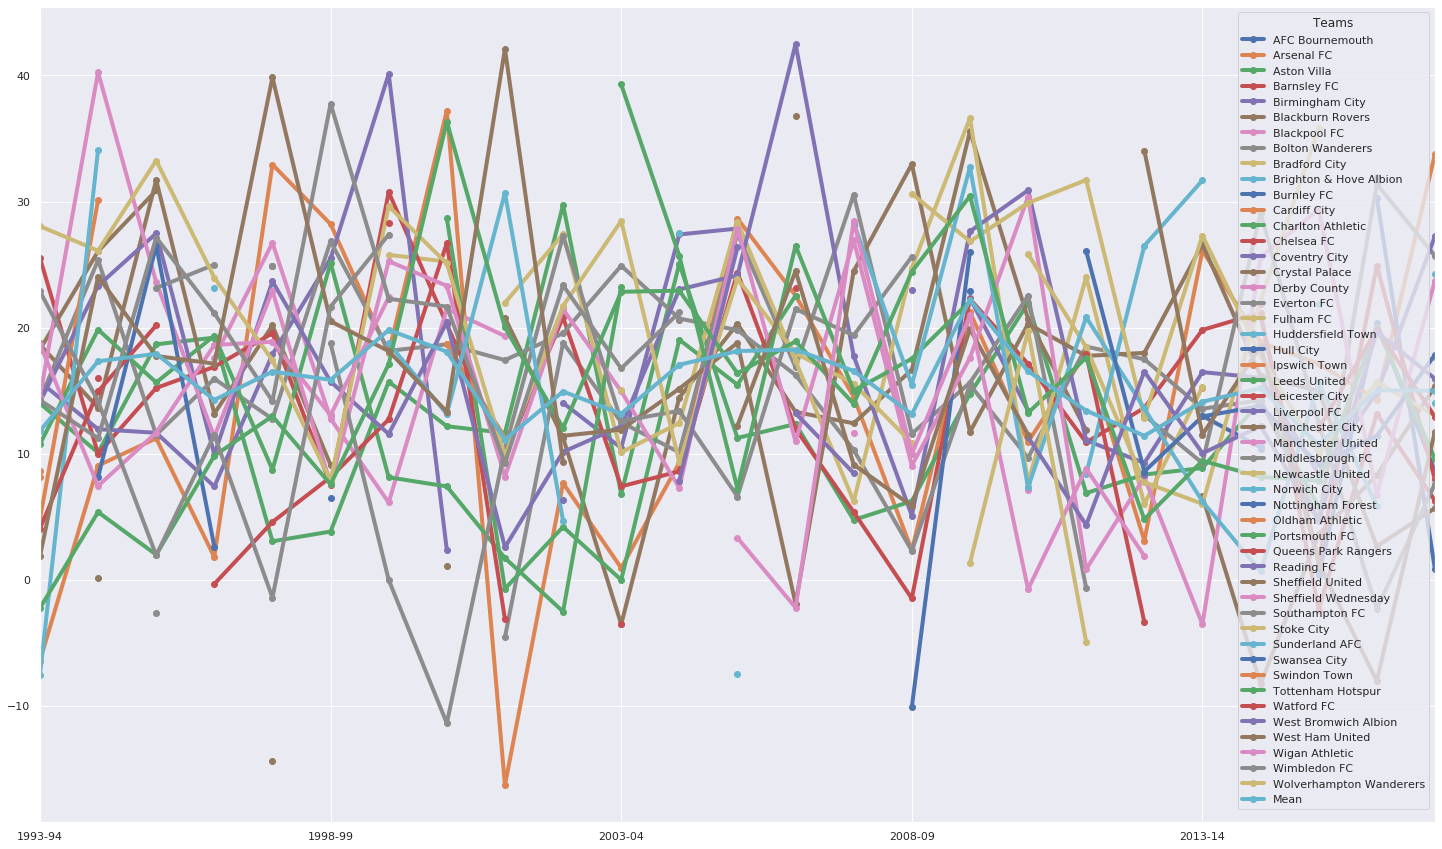

In [ ]:
sns.set(rc={'figure.figsize':(25,15)})
transposed.plot.line(marker='o', linewidth=4)

We plot the home advantage score figures for Leicester City and Manchester United, since they both shone as outliers during the analysis

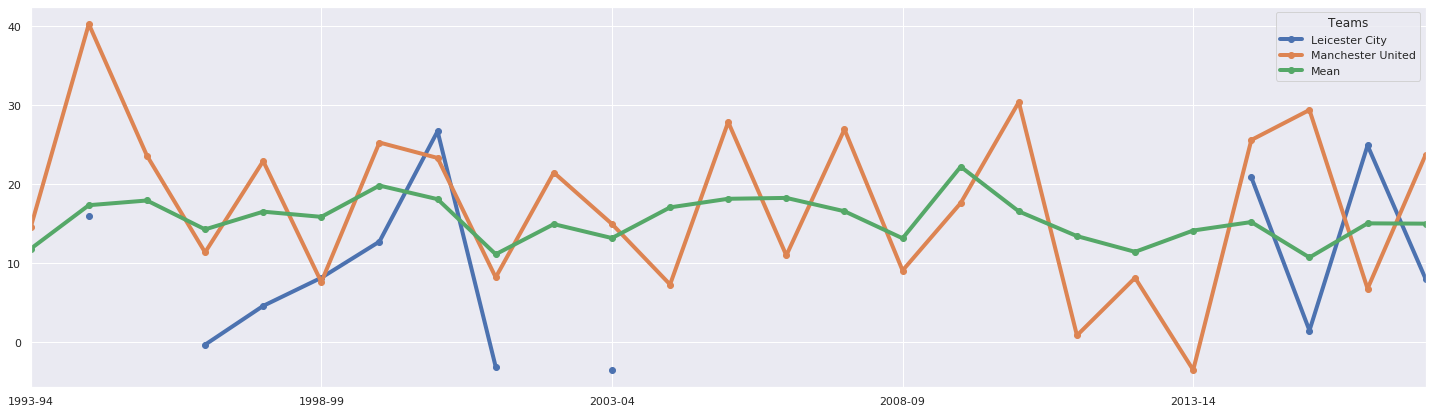

In [ ]:
sns.set(rc={'figure.figsize':(25,7)})
transposed[['Leicester City', 'Manchester United', 'Mean']].plot.line(marker='o', linewidth=4)

## Average Scoring Margin

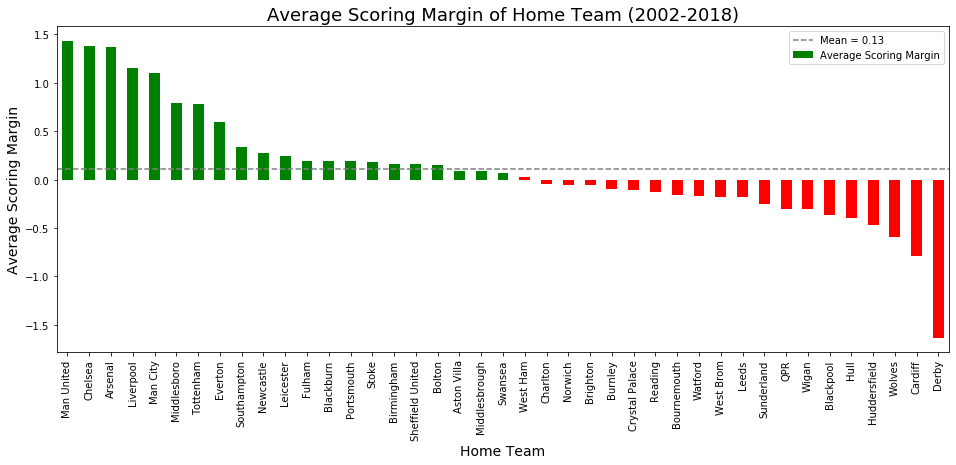

In [ ]:
# Goal Difference equals to number of hometeam goals minus number of awayteam goals
margin_score = cleaned_df.groupby(['HomeTeam']).agg({'GoalsDifference': ['sum','size']})
margin_score = margin_score.reset_index()
margin_score.columns = margin_score.columns.droplevel(level=0)
# print(margin_score)

# Scoring Margin is the average difference between the number of goals scored by the home and away team 
# A positive Scoring Margin = home team scores more than away team
margin_score['AverageScoringMargin'] = margin_score['sum']/margin_score['size']
result_score = margin_score.sort_values(['AverageScoringMargin'], ascending = False)

# Show bar chart 
fig, ax = plt.subplots() 
team_list = []
for x in list(result_score['AverageScoringMargin']):
    if round(x,1) <= 0:
        team_list.append('red')
    else:
        team_list.append('green')
result_score.plot(x='', y = "AverageScoringMargin", kind='bar',ax=ax, figsize=DIMS, color=team_list, label = 'Average Scoring Margin')
ax.set_title('Average Scoring Margin of Home Team (2002-2018)', fontsize = 18)
ax.set_ylabel('Average Scoring Margin', fontsize = 14)
ax.set_xlabel('Home Team', fontsize = 14)
plt.axhline(y=result_score["AverageScoringMargin"].mean(),color='gray',linestyle='--', label='Mean = 0.13')
legend = ax.legend(loc='upper right')
ax.grid(False)
plt.show()

In [ ]:
# Checking for correctness
result_score.head(5)

,,sum,size,AverageScoringMargin
22,Man United,435,304,1.430921
11,Chelsea,419,304,1.378289
0,Arsenal,417,304,1.371711
20,Liverpool,352,304,1.157895
21,Man City,334,304,1.098684


## Referee Analysis

### Average Foul Margin

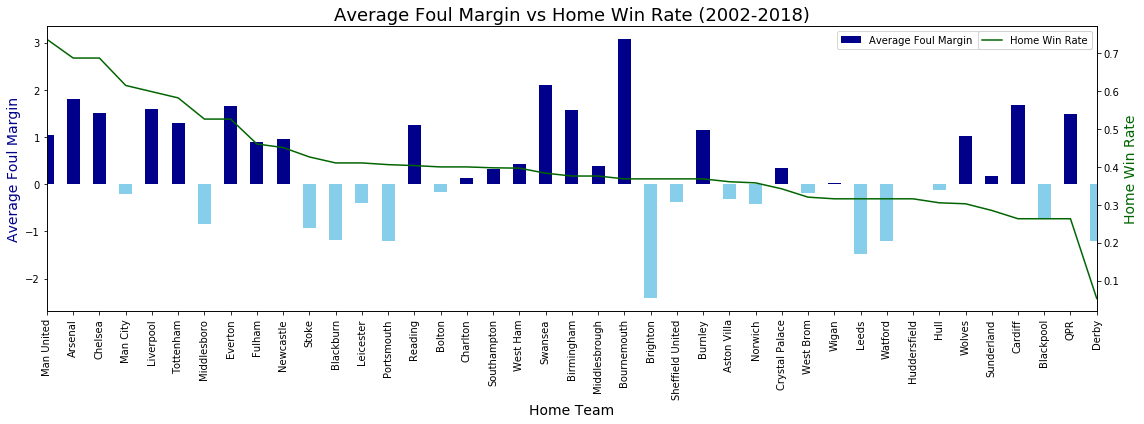

In [ ]:
# The FoulDifference refers to the number of fouls committed by hometeam minus the number of fouls by the awayteam
cleaned_df['FoulDifference'] = cleaned_df['AF'] - cleaned_df['HF']
margin_foul = cleaned_df.groupby(['HomeTeam']).agg({'FoulDifference': ['sum','size']})
margin_foul = margin_foul.reset_index()
margin_foul.columns = margin_foul.columns.droplevel(level=0)

# The more positive the foul margin, the higher the number of away fouls committed compared to the home fouls
margin_foul['AverageFoulMargin'] = margin_foul['sum']/margin_foul['size']

# Calculating the win rate of each seperate team
winrate = cleaned_df.copy()
aggregate_winrate = winrate.groupby(['HomeTeam', 'FTR']).size().reset_index(name="No. of teams")
result_winrate = pd.pivot_table(aggregate_winrate, index=['HomeTeam'], columns=['FTR'],
                                        values='No. of teams', aggfunc=np.sum)
result_winrate = result_winrate.reset_index()
result_winrate['HomeWinRate'] = result_winrate['H'] / (result_winrate['H'] + result_winrate['A'] + result_winrate['D'])
result_winrate = result_winrate.sort_values(['HomeWinRate'], ascending = False)

margin_foul['HomeWinRate'] = result_winrate['H'] / (result_winrate['H'] + result_winrate['A'] + result_winrate['D'])
margin_foul = margin_foul.sort_values(['HomeWinRate'], ascending = False)

margin_foul['positive'] = margin_foul['AverageFoulMargin'] > 0

# Plotting bar chart (average foul margin)
fig, ax = plt.subplots()
margin_foul.plot(x='', y = "AverageFoulMargin", kind='bar',ax=ax, figsize=DIMS, color=margin_foul.positive.map({True: 'darkblue', False: 'skyblue'}), rot = 90)
ax.set_title('Average Foul Margin vs Home Win Rate (2002-2018)', fontsize = 18)
ax.set_ylabel('Average Foul Margin', color ='darkblue', fontsize = 14)
ax.set_xlabel('Home Team', fontsize = 14)

# Plotting line graph (win rate)
ax_new = ax.twinx()
result_winrate.plot(x='HomeTeam',y = "HomeWinRate", kind='line',ax=ax_new, figsize=DIMS, color='darkgreen')
ax_new.set_ylabel('Home Win Rate', color = 'darkgreen', fontsize = 14)
ax.legend(['Average Foul Margin                                     '])
ax_new.legend(['Home Win Rate'])
ax_new.grid(False)
fig.tight_layout()
plt.show()

### Yellow Card Margin

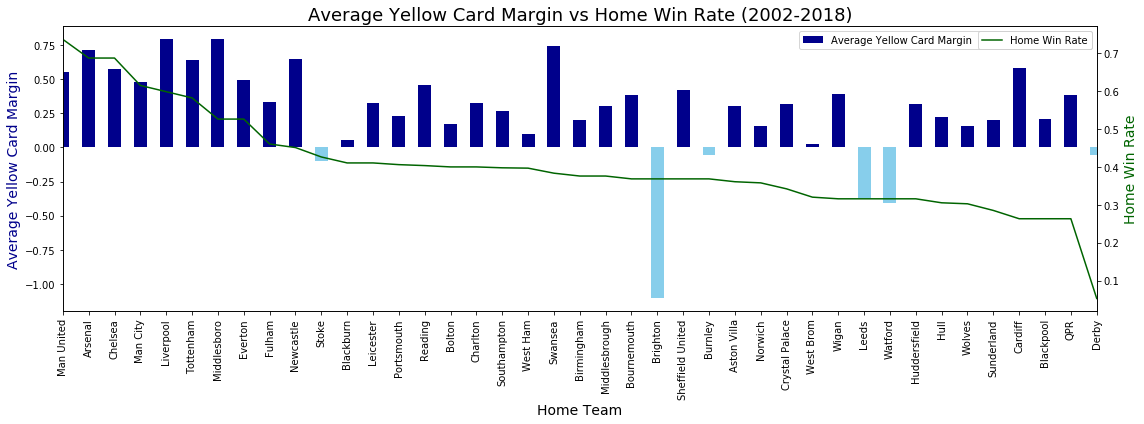

In [ ]:
# YellowDifference refers to the number of yellow cards by awayteam minus number of yellow cards by hometeam
cleaned_df['YellowDifference'] = cleaned_df['AY'] - cleaned_df['HY']
margin_yellow_card = cleaned_df.groupby(['HomeTeam']).agg({'YellowDifference': ['sum','size']})
margin_yellow_card = margin_yellow_card.reset_index()
margin_yellow_card.columns = margin_yellow_card.columns.droplevel(level=0)

# The more positive the yellow card margin, the higher the number of awayteam yellow cards compared to the hometeam yellow cards
margin_yellow_card['AverageYellowMargin'] = margin_yellow_card['sum']/margin_yellow_card['size']
margin_yellow_card['HomeWinRate'] = result_winrate['H'] / (result_winrate['H'] + result_winrate['A'] + result_winrate['D'])
margin_yellow_card = margin_yellow_card.sort_values(['HomeWinRate'], ascending = False)

margin_yellow_card['positive'] = margin_yellow_card['AverageYellowMargin'] > 0

# Plotting bar chart  (yellow card margin)
fig, ax = plt.subplots()
margin_yellow_card.plot(x='', y = "AverageYellowMargin", kind='bar',ax=ax, figsize=DIMS, color=margin_yellow_card.positive.map({True: 'darkblue', False: 'skyblue'}), rot = 90)
ax.set_title('Average Yellow Card Margin vs Home Win Rate (2002-2018)', fontsize = 18)
ax.set_ylabel('Average Yellow Card Margin', color ='darkblue', fontsize = 14)
ax.set_xlabel('Home Team', fontsize = 14)

# Plotting line graph (win rate)
ax_new = ax.twinx()
result_winrate.plot(x='HomeTeam',y = "HomeWinRate", kind='line',ax=ax_new, figsize=DIMS, color='darkgreen')
ax_new.set_ylabel('Home Win Rate', color = 'darkgreen', fontsize = 14)
ax.legend(['Average Yellow Card Margin                                     '])
ax_new.legend(['Home Win Rate'])
ax_new.grid(False)
fig.tight_layout()
plt.show()

### Red Card Margin

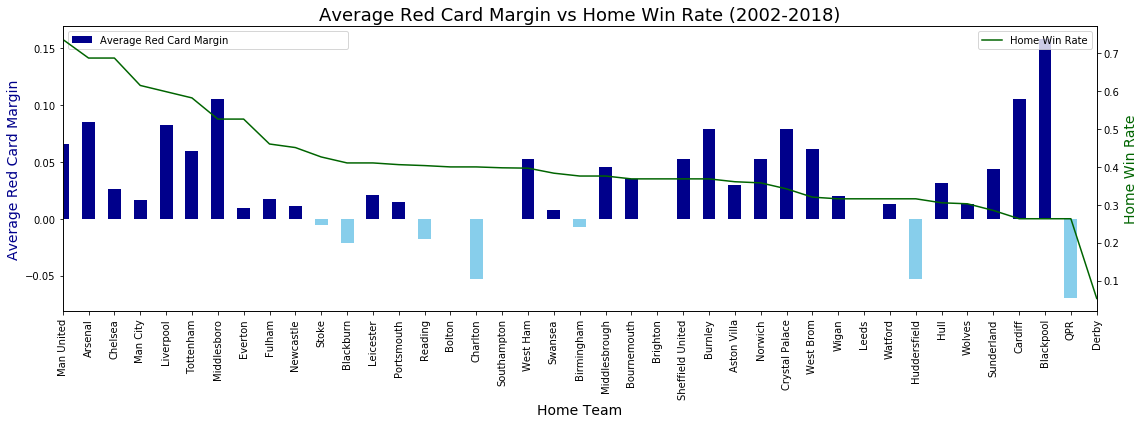

In [ ]:
# RedDifference refers to the number of red cards by awayteam minus number of red cards by hometeam
cleaned_df['RedDifference'] = cleaned_df['AR'] - cleaned_df['HR']
margin_red_card = cleaned_df.groupby(['HomeTeam']).agg({'RedDifference': ['sum','size']})
margin_red_card = margin_red_card.reset_index()
margin_red_card.columns = margin_red_card.columns.droplevel(level=0)

# The more positive the red card margin, the higher the number of awayteam red cards compared to the hometeam red cards
margin_red_card['AverageRedMargin'] = margin_red_card['sum']/margin_red_card['size']
margin_red_card['HomeWinRate'] = result_winrate['H'] / (result_winrate['H'] + result_winrate['A'] + result_winrate['D'])
margin_red_card = margin_red_card.sort_values(['HomeWinRate'], ascending = False)


margin_red_card['positive'] = margin_red_card['AverageRedMargin'] > 0

# Plotting bar chart  (red card margin)
fig, ax = plt.subplots()
margin_red_card.plot(x='', y = "AverageRedMargin", kind='bar',ax=ax, figsize=DIMS, color=margin_red_card.positive.map({True: 'darkblue', False: 'skyblue'}), rot = 90)
ax.set_title('Average Red Card Margin vs Home Win Rate (2002-2018)', fontsize = 18)
ax.set_ylabel('Average Red Card Margin', color ='darkblue', fontsize = 14)
ax.set_xlabel('Home Team', fontsize = 14)

# Plotting line graph (win rate)
ax_new = ax.twinx()
result_winrate.plot(x='HomeTeam',y = "HomeWinRate", kind='line',ax=ax_new, figsize=DIMS, color='darkgreen')
ax_new.set_ylabel('Home Win Rate', color = 'darkgreen', fontsize = 14)
ax.legend(['Average Red Card Margin                                     '])
ax_new.legend(['Home Win Rate'])
ax_new.grid(False)
fig.tight_layout()
plt.show()

In [ ]:
# Checking if done correct
margin_red_card.head(5)

,,sum,size,AverageRedMargin,HomeWinRate,positive
22,Man United,20,304,0.065789,0.736842,True
0,Arsenal,26,304,0.085526,0.687500,True
11,Chelsea,8,304,0.026316,0.687500,True
21,Man City,5,304,0.016447,0.615132,True
20,Liverpool,25,304,0.082237,0.598684,True


### Referee Bias

In [ ]:
cleaned_df['RefereeBias'] = (cleaned_df['AY'] + 2 * cleaned_df['AR']) - (cleaned_df['HY'] + 2* cleaned_df['HR'])
referee_reputation = cleaned_df.groupby(['Referee']).agg({'RefereeBias': ['sum','size']})
referee_reputation = referee_reputation.reset_index()
referee_reputation.columns = referee_reputation.columns.droplevel(level=0)

referee_reputation['AverageRefereeReputation'] = referee_reputation['sum']/referee_reputation['size']
referee_reputation = referee_reputation.sort_values(by=['AverageRefereeReputation'],ascending=False)
referee_reputation.columns =['Referee', 'sum', 'size', 'RefereeReputation'] 
referee_reputation.head(5)

,Referee,sum,size,RefereeReputation
9,D Coote,2,1,2.000000
49,S Tanner,28,26,1.076923
40,R Beeby,3,3,1.000000
8,C Wilkes,8,8,1.000000
12,D Pugh,5,5,1.000000


In [ ]:
# Only giving trusted score to experiences referees (more than 10 games)
updated_referee = referee_reputation[referee_reputation['size'] > 10] 
#updated_referee 

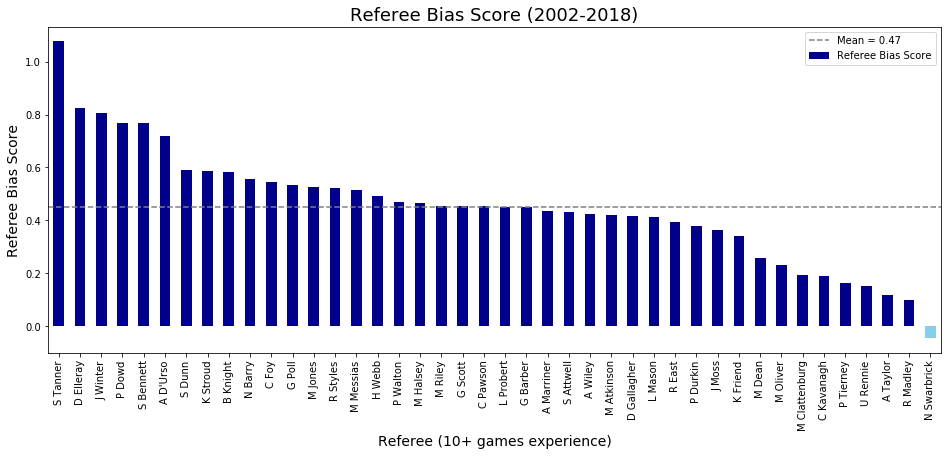

In [ ]:
# Plot the bar chart (referee bias)
fig, ax = plt.subplots() 
clrs = []
for i in list(updated_referee['RefereeReputation']):
    if round(i,1) <= 0:
        clrs.append('skyblue')
    else:
        clrs.append('darkblue')
#plt.ylim(-0.5, 1.5)
updated_referee.plot(x='Referee', y = "RefereeReputation", kind='bar',ax=ax, figsize=DIMS, color=clrs, label = 'Referee Bias Score')
ax.set_title('Referee Bias Score (2002-2018)', fontsize = 18)
ax.set_ylabel('Referee Bias Score', fontsize = 14)
ax.set_xlabel('Referee (10+ games experience)', fontsize = 14)
plt.axhline(y=updated_referee["RefereeReputation"].mean(),color='gray',linestyle='--', label='Mean = 0.47')
legend = ax.legend(loc='upper right')
ax.grid(False)
plt.show()

In [ ]:
# Check if inexperienced referee got deleted
cleaned_df.loc[cleaned_df['Referee'] == 'Roy Burton']

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Referee,HF,AF,HY,AY,HR,AR,Season,GoalsDifference,FoulDifference,YellowDifference,RedDifference,RefereeBias


In [ ]:
# Merging
cleaned_df = pd.merge(cleaned_df, referee_reputation, how='left')
cleaned_df.head(5)

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Referee,HF,AF,HY,AY,HR,AR,Season,GoalsDifference,FoulDifference,YellowDifference,RedDifference,RefereeBias,sum,size,RefereeReputation
0,2002-08-17,Blackburn,Sunderland,0,0,D,D Elleray,14,11,1,2,0,0,02-03,0,-3,1,0,1,14,17,0.823529
1,2002-08-17,Charlton,Chelsea,2,3,A,G Barber,10,12,0,3,1,0,02-03,-1,2,3,-1,1,18,40,0.450000
2,2002-08-17,Everton,Tottenham,2,2,D,N Barry,18,4,1,1,0,0,02-03,0,-14,0,0,0,34,61,0.557377
3,2002-08-17,Fulham,Bolton,4,1,H,A Wiley,16,12,1,2,0,0,02-03,3,-4,1,0,1,88,207,0.425121
4,2002-08-17,Leeds,Man City,3,0,H,G Poll,13,13,1,1,0,0,02-03,3,0,0,0,0,74,139,0.532374


## Season Home Goals vs Away Goals

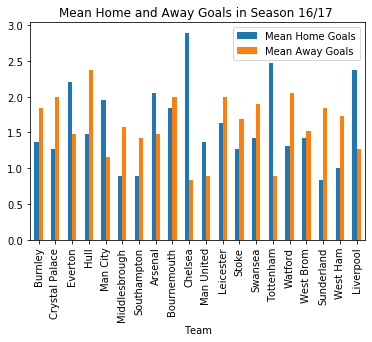

In [ ]:
# Checking for mean home goals vs mean away goals for season 16/17
Season16_17 = cleaned_df[cleaned_df['Season'] == '16-17']
team_list = cleaned_df[cleaned_df['Season'] == '16-17']['HomeTeam'].unique()

home_points_list = []
away_points_list = []
for i in team_list:
    hometeam_df = Season16_17[Season16_17['HomeTeam'] == i]
    awayteam_df = Season16_17[Season16_17['AwayTeam'] == i]
    hometeam = hometeam_df['HomeTeam'] == i
    awayteam = awayteam_df['AwayTeam'] == i
    home_points_list.append(hometeam_df.loc[hometeam,'FTHG'].mean())
    away_points_list.append(awayteam_df.loc[awayteam, 'FTHG'].mean())
dataframe = pd.DataFrame({'Team':team_list,'Mean Home Goals': home_points_list,'Mean Away Goals' : away_points_list})
dataframe.set_index('Team', inplace=True)
dataframe.plot(kind='bar',title='Mean Home and Away Goals in Season 16/17 ')

In [ ]:
cleaned_df.head(5)

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Referee,HF,AF,HY,AY,HR,AR,Season,GoalsDifference,FoulDifference,YellowDifference,RedDifference,RefereeBias,sum,size,RefereeReputation
0,2002-08-17,Blackburn,Sunderland,0,0,D,D Elleray,14,11,1,2,0,0,02-03,0,-3,1,0,1,14,17,0.823529
1,2002-08-17,Charlton,Chelsea,2,3,A,G Barber,10,12,0,3,1,0,02-03,-1,2,3,-1,1,18,40,0.450000
2,2002-08-17,Everton,Tottenham,2,2,D,N Barry,18,4,1,1,0,0,02-03,0,-14,0,0,0,34,61,0.557377
3,2002-08-17,Fulham,Bolton,4,1,H,A Wiley,16,12,1,2,0,0,02-03,3,-4,1,0,1,88,207,0.425121
4,2002-08-17,Leeds,Man City,3,0,H,G Poll,13,13,1,1,0,0,02-03,3,0,0,0,0,74,139,0.532374


In [ ]:
season_stats_23 = cleaned_df.loc[cleaned_df['Season'] == '02-03'] 
season_stats_34 = cleaned_df.loc[cleaned_df['Season'] == '03-04']                    
season_stats_45 = cleaned_df.loc[cleaned_df['Season'] == '04-05']  
season_stats_56 = cleaned_df.loc[cleaned_df['Season'] == '05-06'] 
season_stats_67 = cleaned_df.loc[cleaned_df['Season'] == '06-07']                    
season_stats_78 = cleaned_df.loc[cleaned_df['Season'] == '07-08']  
season_stats_89 = cleaned_df.loc[cleaned_df['Season'] == '08-09'] 
season_stats_910 = cleaned_df.loc[cleaned_df['Season'] == '09-10']                    
season_stats_1011 = cleaned_df.loc[cleaned_df['Season'] == '10-11']  
season_stats_1112 = cleaned_df.loc[cleaned_df['Season'] == '11-12'] 
season_stats_1213 = cleaned_df.loc[cleaned_df['Season'] == '12-13']                    
season_stats_1314 = cleaned_df.loc[cleaned_df['Season'] == '13-14']  
season_stats_1415 = cleaned_df.loc[cleaned_df['Season'] == '14-15'] 
season_stats_1516 = cleaned_df.loc[cleaned_df['Season'] == '15-16']                    
season_stats_1617 = cleaned_df.loc[cleaned_df['Season'] == '16-17']  
season_stats_1718 = cleaned_df.loc[cleaned_df['Season'] == '17-18'] 

Text(0, 0.5, 'Total')

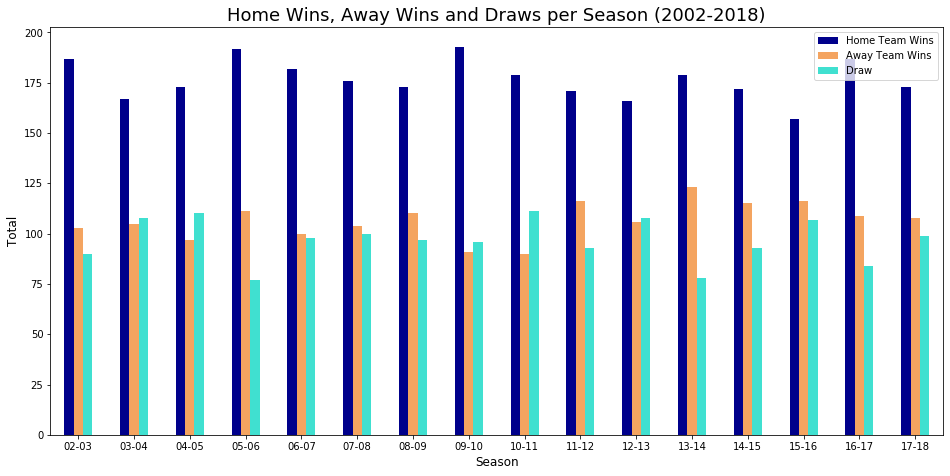

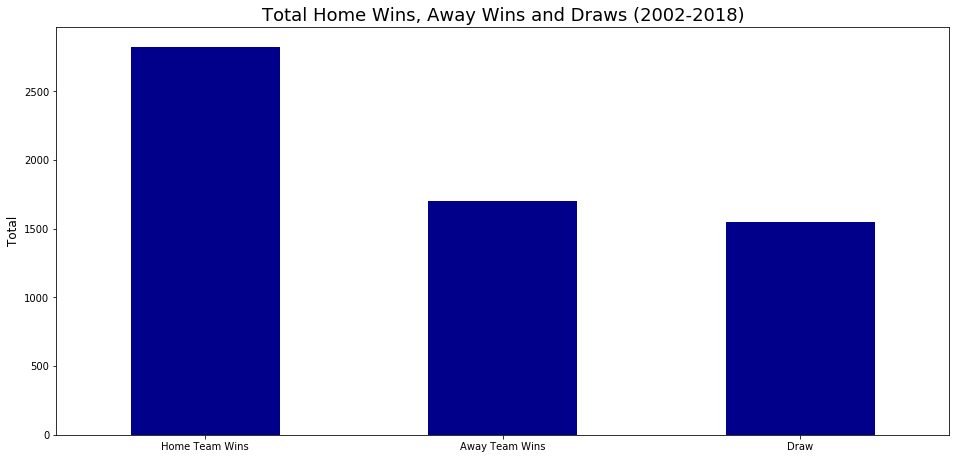

In [ ]:
def season_results(playing_stats, year):
    return pd.DataFrame(data = [ len(playing_stats[playing_stats.FTR == 'H']),
                                 len(playing_stats[playing_stats.FTR == 'A']),
                                 len(playing_stats[playing_stats.FTR == 'D'])],
                                index = ['Home Team Wins', 'Away Team Wins', 'Draw'], columns =[year]).T

season_aggregated = season_results(cleaned_df, 'Overall')
season_23 = season_results(season_stats_23, '02-03')
season_34 = season_results(season_stats_34, '03-04')
season_45 = season_results(season_stats_45, '04-05')
season_56 = season_results(season_stats_56, '05-06')
season_67 = season_results(season_stats_67, '06-07')
season_78 = season_results(season_stats_78, '07-08')
season_89 = season_results(season_stats_89, '08-09')
season_910 = season_results(season_stats_910, '09-10')
season_1011 = season_results(season_stats_1011, '10-11')
season_1112 = season_results(season_stats_1112, '11-12')
season_1213 = season_results(season_stats_1213, '12-13')
season_1314 = season_results(season_stats_1314, '13-14')
season_1415 = season_results(season_stats_1415, '14-15')
season_1516 = season_results(season_stats_1516, '15-16')
season_1617 = season_results(season_stats_1617, '16-17')
season_1718 = season_results(season_stats_1718, '17-18')

season_stats = pd.concat([season_23, season_34, season_45,
                          season_56, season_67, season_78, season_89, season_910,
                          season_1011, season_1112, season_1213, season_1314, season_1415,
                          season_1516, season_1617, season_1718])

# Plotting home wins, away wins and draws
ax = season_stats.plot(kind='bar', color = ['darkblue','sandybrown', 'turquoise'], figsize = [16,7.5])
ax.set_title('Home Wins, Away Wins and Draws per Season (2002-2018)', size=18)
plt.xticks(rotation=0)
ax.set_ylabel('Total', size=12)
ax.set_xlabel('Season', size=12)

# Plotting aggregated result dataframe
ax_new = season_aggregated.T.plot(kind='bar', color=['darkblue'], figsize = [16,7.5], 
                      legend = False)
ax_new.set_title('Total Home Wins, Away Wins and Draws (2002-2018)', size=18)

plt.xticks(rotation=0)
ax_new.set_ylabel('Total', size=12)

In [ ]:
# Checking for correctness (each season)
season_stats.head(5)

,Home Team Wins,Away Team Wins,Draw
02-03,187,103,90
03-04,167,105,108
04-05,173,97,110
05-06,192,111,77
06-07,182,100,98


In [ ]:
season_aggregated

,Home Team Wins,Away Team Wins,Draw
Overall,2827,1704,1549


In [ ]:
slicing_season = season_stats.T

for i in slicing_season.columns:
    slicing_season[i] = (slicing_season[i] * 100) / 380  

# Renaming the columns
slicing_season.rename(index={'Home Wins':'Home', 'Away Wins':'Away', 'Draws':'Draw'}, inplace=True)
slicing_season

,02-03,03-04,04-05,05-06,06-07,07-08,08-09,09-10,10-11,11-12,12-13,13-14,14-15,15-16,16-17,17-18
Home Team Wins,49.210526,43.947368,45.526316,50.526316,47.894737,46.315789,45.526316,50.789474,47.105263,45.000000,43.684211,47.105263,45.263158,41.315789,49.210526,45.526316
Away Team Wins,27.105263,27.631579,25.526316,29.210526,26.315789,27.368421,28.947368,23.947368,23.684211,30.526316,27.894737,32.368421,30.263158,30.526316,28.684211,28.421053
Draw,23.684211,28.421053,28.947368,20.263158,25.789474,26.315789,25.526316,25.263158,29.210526,24.473684,28.421053,20.526316,24.473684,28.157895,22.105263,26.052632


([<matplotlib.axis.XTick at 0x7f35e9e97f98>,
 <a list of 16 Text xticklabel objects>)

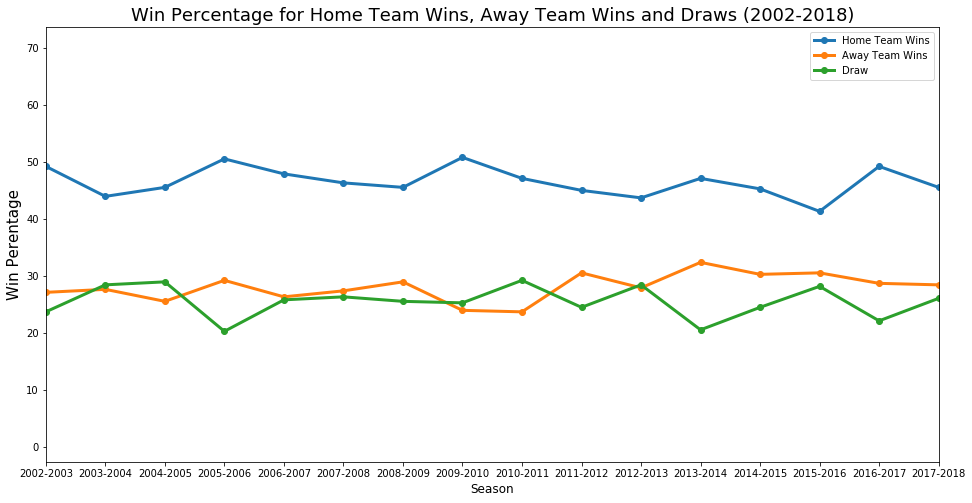

In [ ]:
# Plotting line plot of the win percentages for all the different seasons in dataframe
ax = slicing_season.T.plot(figsize = [16,8], marker = 'o', linewidth = 3)
ax.margins(y=.75)
ax.set_title('Win Percentage for Home Team Wins, Away Team Wins and Draws (2002-2018)', size=18)
ax.set_xlabel('Season', size =12)
ax.set_ylabel('Win Perentage', size =15)
# Set season labels
plt.xticks( np.arange(16), ('2002-2003', '2003-2004', '2004-2005', '2005-2006', '2006-2007', '2007-2008', '2008-2009', '2009-2010',
                            '2010-2011', '2011-2012', '2012-2013', '2013-2014', '2014-2015', '2015-2016', '2016-2017', '2017-2018') )

,Win Percentage
Home Team Wins,46.496711
Away Team Wins,28.026316
Draw,25.476974


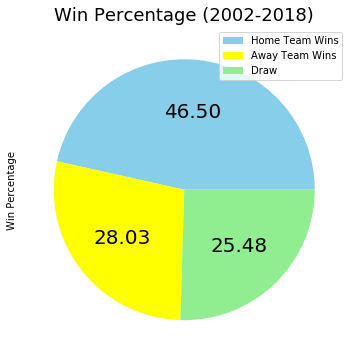

In [ ]:
# Calculating the average win percentage for the pie chart
result_average_season = pd.DataFrame((slicing_season['02-03'] + slicing_season['03-04'] + slicing_season['04-05'] +
                                slicing_season['05-06'] + slicing_season['06-07'] + slicing_season['07-08'] +
                                slicing_season['08-09'] + slicing_season['09-10'] + slicing_season['10-11'] + 
                                slicing_season['11-12'] + slicing_season['12-13'] + slicing_season['13-14'] + 
                                slicing_season['14-15'] + slicing_season['15-16'] + slicing_season['16-17'] + slicing_season['17-18']) / 16, 
                                columns = ['Win Percentage'])

# Plotting average win percentage
ax = result_average_season.plot(kind='pie', figsize =[6,6],autopct='%.2f', y='Win Percentage', fontsize =20, labels = None,
                          legend = True, colors = ['skyblue','yellow', 'lightgreen'])
ax.set_title('Win Percentage (2002-2018)', size=18)
result_average_season

## Late Season Statistics

In [ ]:
# Setting months
cleaned_df['Month'] = pd.DatetimeIndex(cleaned_df['Date']).month.astype(int)

# Ending season if month is 5 or 6 (April - May)
cleaned_df['EndingSeason'] = np.where(((cleaned_df['Month']== 5) | (cleaned_df['Month']== 4 )), 'Yes', 'No')

# Checking if EndingSeason is set to 'Yes' correctly
cleaned_df.loc[cleaned_df['Month'] == 4].head(5)

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Referee,HF,AF,HY,AY,HR,AR,Season,GoalsDifference,FoulDifference,YellowDifference,RedDifference,RefereeBias,sum,size,RefereeReputation,Month,EndingSeason
310,2003-04-05,Aston Villa,Arsenal,1,1,D,U Rennie,19,12,1,2,0,0,02-03,0,-7,1,0,1,15,100,0.150000,4,Yes
311,2003-04-05,Bolton,Man City,2,0,H,C Wilkes,6,10,0,5,0,0,02-03,2,4,5,0,5,8,8,1.000000,4,Yes
312,2003-04-05,Charlton,Leeds,1,6,A,E Wolstenholme,14,17,2,1,0,0,02-03,-5,3,-1,0,-1,3,9,0.333333,4,Yes
313,2003-04-05,Man United,Liverpool,4,0,H,M Riley,15,17,1,3,0,1,02-03,4,2,2,1,4,77,169,0.455621,4,Yes
314,2003-04-05,Middlesboro,West Brom,3,0,H,M Halsey,9,15,0,1,0,0,02-03,3,6,1,0,1,106,228,0.464912,4,Yes


In [ ]:
# New dataframe with early season (August - March)
early_season = cleaned_df[cleaned_df['EndingSeason'] == 'No']
early_season.head(2)

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Referee,HF,AF,HY,AY,HR,AR,Season,GoalsDifference,FoulDifference,YellowDifference,RedDifference,RefereeBias,sum,size,RefereeReputation,Month,EndingSeason
0,2002-08-17,Blackburn,Sunderland,0,0,D,D Elleray,14,11,1,2,0,0,02-03,0,-3,1,0,1,14,17,0.823529,8,No
1,2002-08-17,Charlton,Chelsea,2,3,A,G Barber,10,12,0,3,1,0,02-03,-1,2,3,-1,1,18,40,0.450000,8,No


In [ ]:
# New dataframe with late season 
late_season = cleaned_df[cleaned_df['EndingSeason'] == 'Yes']
late_season_2015 = late_season[late_season['Season'] == '15-16']
late_season_2015.head(2)

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Referee,HF,AF,HY,AY,HR,AR,Season,GoalsDifference,FoulDifference,YellowDifference,RedDifference,RefereeBias,sum,size,RefereeReputation,Month,EndingSeason
5243,2016-04-02,Arsenal,Watford,4,0,H,A Taylor,7,10,1,1,0,0,15-16,4,3,0,0,0,23,194,0.118557,4,Yes
5244,2016-04-02,Aston Villa,Chelsea,0,4,A,N Swarbrick,12,8,4,1,1,0,15-16,-4,-4,-3,-1,-5,-6,132,-0.045455,4,Yes


In [ ]:
# Calculate the win rate of each team
winrate_late = late_season_2015.copy()
winrate_aggregate_late = winrate_late.groupby(['HomeTeam', 'FTR']).size().reset_index(name="Number of teams")
result_winrate_late = pd.pivot_table(winrate_aggregate_late, index=['HomeTeam'], columns=['FTR'],
                                        values='Number of teams', aggfunc=np.sum)
result_winrate_late = result_winrate_late.reset_index()
result_winrate_late.fillna(0, inplace=True)
result_winrate_late['HomeWinRate'] = result_winrate_late['H'] / (result_winrate_late['H'] + result_winrate_late['A'] + result_winrate_late['D'])
result_winrate_late = result_winrate_late.sort_values(['HomeWinRate'], ascending = False)
result_winrate_late.head(2)

FTR,HomeTeam,A,D,H,HomeWinRate
12,Southampton,0.0,0.0,3.0,1.0
0,Arsenal,0.0,1.0,4.0,0.8


In [ ]:
result_winrate_late.drop(['A', 'D', 'H'], inplace=True, axis=1)

In [ ]:
# New dataframe with early season 
early_season = cleaned_df[cleaned_df['EndingSeason'] == 'No']
early_season_2015 = early_season[early_season['Season'] == '15-16']
early_season_2015.head(2)

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Referee,HF,AF,HY,AY,HR,AR,Season,GoalsDifference,FoulDifference,YellowDifference,RedDifference,RefereeBias,sum,size,RefereeReputation,Month,EndingSeason
4940,2015-08-08,Bournemouth,Aston Villa,0,1,A,M Clattenburg,13,13,3,4,0,0,15-16,-1,0,1,0,1,57,293,0.194539,8,No
4941,2015-08-08,Chelsea,Swansea,2,2,D,M Oliver,15,16,1,3,1,0,15-16,0,1,2,-1,0,47,204,0.230392,8,No


In [ ]:
# Calculate the win rate of each team
winrate_early = early_season_2015.copy()
winrate_aggregate_early = winrate_early.groupby(['HomeTeam', 'FTR']).size().reset_index(name="Number of teams")
result_winrate_early = pd.pivot_table(winrate_aggregate_early, index=['HomeTeam'], columns=['FTR'],
                                        values='Number of teams', aggfunc=np.sum)
result_winrate_early = result_winrate_early.reset_index()
result_winrate_early.fillna(0, inplace=True)
result_winrate_early['HomeWinRate'] = result_winrate_early['H'] / (result_winrate_early['H'] + result_winrate_early['A'] + result_winrate_early['D'])
result_winrate_early = result_winrate_early.sort_values(['HomeWinRate'], ascending = False)
result_winrate_early.head(2)

FTR,HomeTeam,A,D,H,HomeWinRate
8,Man City,5,1,10,0.625
6,Leicester,1,5,9,0.600


In [ ]:
# Dropping columns
result_winrate_early.drop(['A', 'D', 'H'], inplace=True, axis=1)

In [ ]:
result_winrate_early['HomeWinRateLate'] = result_winrate_late['HomeWinRate']
result_winrate_early['HomeWinRateEarly'] = result_winrate_early['HomeWinRate']
result_winrate_early.drop(['HomeWinRate'], inplace=True, axis=1)
result = result_winrate_early

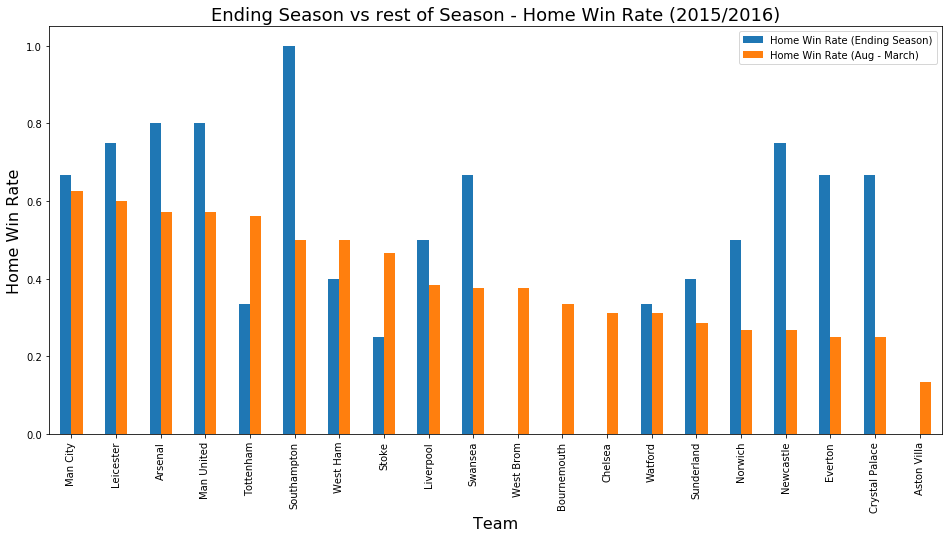

In [ ]:
# Plotting graph ending season vs rest of season
ax = result.plot.bar(x='HomeTeam', y=["HomeWinRateLate", "HomeWinRateEarly"], rot=0, label = ("Home Win Rate (Ending Season)", "Home Win Rate (Aug - March)"), figsize = [16,7.5])
plt.xticks(rotation=90)
plt.xlabel('Team', fontsize=16)
plt.ylabel('Home Win Rate', fontsize=16)
plt.title('Ending Season vs rest of Season - Home Win Rate (2015/2016)',fontsize=18)
plt.legend()

In [ ]:
arrest_df = pd.read_csv('https://raw.githubusercontent.com/harditsingh/DataWranglingVU/master/Project/arrests_final.csv')

In [ ]:
arrest_df_2015 = arrest_df[arrest_df['Season'] == '2015-16']
arrest_df_2015.columns = arrest_df_2015.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
arrest_df_2015.sort_values("home", axis = 0, ascending = False, inplace = True) 
arrest_df_2015.head(5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,season,club,total,home,away,neutral,violentdisorder,publicdisorder,throwingmissiles,chanting,pitchincursion,alcoholoffences,tickettouting,weaponpossession,pyrotechnicspossession,breachofbo,criminaldamage
21,2015-16,Arsenal,42,22,19,1,7,14,8,0,1,5,1,0,2,0,4
34,2015-16,Sunderland,44,22,22,0,3,9,1,4,15,10,0,0,2,0,0
22,2015-16,Aston Villa,41,20,21,0,8,10,5,0,2,11,0,0,1,2,2
36,2015-16,Tottenham Hotspur,33,18,15,0,6,12,2,0,1,3,5,1,3,0,0
26,2015-16,Leicester City,32,17,15,0,6,10,0,1,8,1,0,0,3,1,2


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:203: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  "'colors' is being deprecated. Please use 'color'"


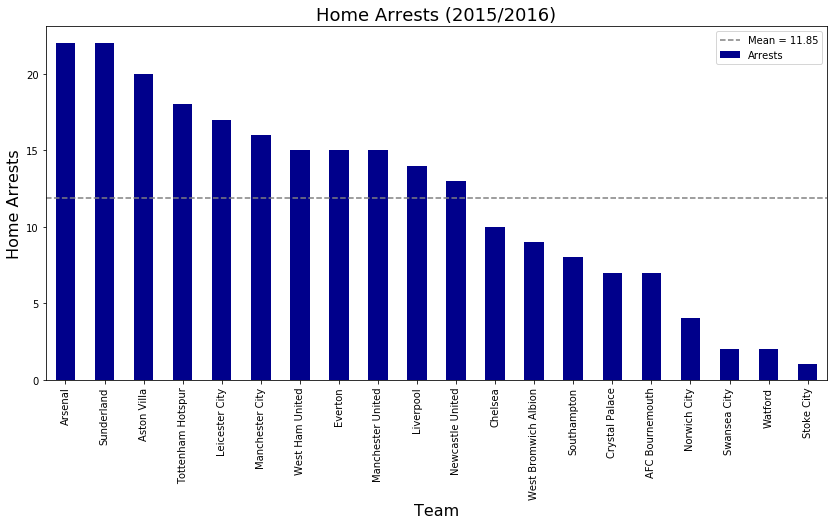

In [ ]:
# Plotting graph for home arrests in season 2015/2016
ax = arrest_df_2015.plot.bar(x='club', y='home', rot=0, label = ("Arrests"), figsize = [14,6.5], colors = 'darkblue')
plt.xticks(rotation=90)
plt.xlabel('Team', fontsize=16)
plt.axhline(y=arrest_df_2015["home"].mean(),color='gray',linestyle='--', label='Mean = 11.85')
plt.ylabel('Home Arrests', fontsize=16)
plt.title('Home Arrests (2015/2016)',fontsize=18)
plt.legend()

In [ ]:
# Final Dataframe
final_df = cleaned_df.drop(columns=['sum', 'size', 'Month', 'RefereeBias'])
final_df = final_df.rename({'GoalsDifference': 'GoalDifference', 'RefereeReputation': 'RefereeBiasScore'}, axis=1) 
final_df

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Referee,HF,AF,HY,AY,HR,AR,Season,GoalDifference,FoulDifference,YellowDifference,RedDifference,RefereeBiasScore,EndingSeason
0,2002-08-17,Blackburn,Sunderland,0,0,D,D Elleray,14,11,1,2,0,0,02-03,0,-3,1,0,0.823529,No
1,2002-08-17,Charlton,Chelsea,2,3,A,G Barber,10,12,0,3,1,0,02-03,-1,2,3,-1,0.450000,No
2,2002-08-17,Everton,Tottenham,2,2,D,N Barry,18,4,1,1,0,0,02-03,0,-14,0,0,0.557377,No
3,2002-08-17,Fulham,Bolton,4,1,H,A Wiley,16,12,1,2,0,0,02-03,3,-4,1,0,0.425121,No
4,2002-08-17,Leeds,Man City,3,0,H,G Poll,13,13,1,1,0,0,02-03,3,0,0,0,0.532374,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6075,2018-05-13,Newcastle,Chelsea,3,0,H,M Atkinson,11,10,0,1,0,0,17-18,3,-1,1,0,0.418338,Yes
6076,2018-05-13,Southampton,Man City,0,1,A,A Marriner,8,10,3,1,0,0,17-18,-1,2,-2,0,0.436620,Yes
6077,2018-05-13,Swansea,Stoke,1,2,A,A Taylor,12,9,1,2,0,0,17-18,-1,-3,1,0,0.118557,Yes
6078,2018-05-13,Tottenham,Leicester,5,4,H,C Pawson,9,13,1,2,0,0,17-18,1,4,1,0,0.453704,Yes
